https://medium.com/@curiousily/making-a-predictive-keyboard-using-recurrent-neural-networks-tensorflow-for-hackers-part-v-3f238d824218

https://www.kaggle.com/hsankesara/books-of-friedrich-nietzsche

In [138]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

In [139]:
import os
#os.chdir('C:\\Users\\prudi\\Desktop\\Data Sets\\books-of-friedrich-nietzsche')
os.chdir('C:\\Users\\Administrator\\Desktop\\Data\\books-of-friedrich-nietzsche')

In [140]:
path = 'The Antichrist.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 185055


In [141]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'unique chars: {len(chars)}')

unique chars: 72


In [142]:
print('len of the text is :',len(text))
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append( text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

len of the text is : 185055
num training examples: 61672


In [143]:
print(text[0:0+40])
print('-'*100)
print(text[40])

ï»¿preface


this book belongs to the mo
----------------------------------------------------------------------------------------------------
s


In [144]:
sentences[0:3]

['ï»¿preface\n\n\nthis book belongs to the mo',
 'preface\n\n\nthis book belongs to the most ',
 'face\n\n\nthis book belongs to the most rar']

In [145]:
print('Len of sentences',len(sentences))
print('Sequence length',SEQUENCE_LENGTH)
print('len of chars is',len(chars))
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Len of sentences 61672
Sequence length 40
len of chars is 72


In [146]:
np.zeros((2,3,4), dtype=np.bool)

array([[[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       [[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]]])

In [147]:
sentences[100]

' born posthumously.\n\nthe conditions unde'

In [148]:
next_chars[100]

'r'

In [149]:
X[0][3]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [150]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [151]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [152]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=1, shuffle=True).history

Train on 58588 samples, validate on 3084 samples
Epoch 1/1
58588/58588 [==============================] - 123s 2ms/step - loss: 2.4246 - acc: 0.3169 - val_loss: 2.3969 - val_acc: 0.3333


In [153]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

In [154]:
model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

In [155]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               102912    
_________________________________________________________________
dense_3 (Dense)              (None, 72)                9288      
_________________________________________________________________
activation_3 (Activation)    (None, 72)                0         
Total params: 112,200
Trainable params: 112,200
Non-trainable params: 0
_________________________________________________________________


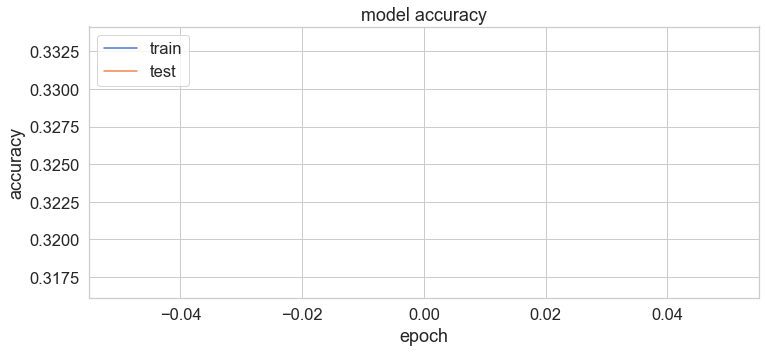

In [156]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

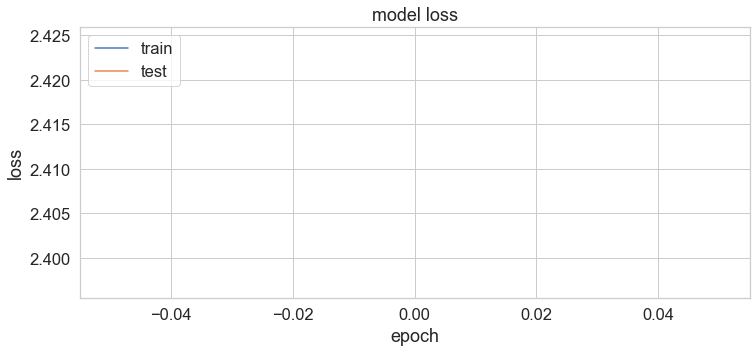

In [157]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [247]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [248]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [266]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        #print('Prepare_input is completed')
        preds = model.predict(x, verbose=0)[0]
        #print('Prediction is completed')
        next_index = sample(preds, top_n=1)[0]
        #print('Next Indexs are created')
        next_char = indices_char[next_index]
        #print(next_char,next_index)
        #print('Next Character are created')
        text = text[1:] + next_char
        completion += next_char
        #print('Completion is ',completion)
        
        #print(len(original_text + completion)+2,len(original_text),next_char )
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            #print('Passed')
            return completion

In [161]:
text="It is not a lack of love, but a lack of friendship that makes unhappy marriages."
text[1:]+indices_char[35]

't is not a lack of love, but a lack of friendship that makes unhappy marriages.e'

In [267]:
def predict_completions(text, n=3):
    #print(text[1:])
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    #print(preds.shape)
    next_indices = sample(preds, n)
    #print(next_indices)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [252]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]


In [216]:
quotes = ["it is not a lack of love,"," it is not a lack of love,  it is not a lack of love,  "]

In [268]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
['the ', 'a ', 'in ', 'his ', 'christions ']

that which does not kill us makes us str
['istions ', 'est ', 'ome ', 'alles ', 'ustions ']

i'm not upset that you lied to me, i'm u
['sthe ', 'ndered ', 't ', 'penter ', 'mperthes ']

and those who were seen dancing were tho
['uld ', ' grest ', 't ', 'ne ', 're ']

it is hard enough to remember my opinion
['s ', ' the ', ', ', 'd ', '. ']

